In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2


In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from dppy.finite_dpps import FiniteDPP
from tqdm import tqdm

from uncertainty_estimator.masks import DPPMask
from dataloader.builder import build_dataset
from uncertainty_estimator.mcdue import MCDUEMasked
from uncertainty_estimator.masks import build_masks
from model.mlp import MLP
from experiments.utils.data import scale

In [3]:
config = {
    'dataset': 'concrete',
    'layers': [8, 128, 128, 64, 1]
}


In [77]:
dataset = build_dataset(config['dataset'])
x_train, y_train = dataset.dataset('train')
x_val, y_val = dataset.dataset('val')

x_train, x_val, _ = scale(x_train, x_val)
y_train, y_val, y_scaler = scale(y_train, y_val)


In [10]:
model = MLP(config['layers'])
model.fit((x_train, y_train), (x_val, y_val))


In [58]:
mask = build_masks(['dpp'])['dpp']
estimator = MCDUEMasked(model, nn_runs=100, dropout_mask=mask)
uncertainty = estimator.estimate(x_val)

In [40]:
def rank(dpp):
    N = dpp.eig_vecs.shape[0]
    tol = np.max(dpp.L_eig_vals) * N * np.finfo(np.float).eps
    rank = np.count_nonzero(dpp.L_eig_vals > tol)
    return rank


In [73]:
k_matrix = mask.layer_correlations[0]
dpp = FiniteDPP('correlation', **{'K': k_matrix})
dpp.sample_exact_k_dpp(1)
rank(dpp)

110

1934

In [95]:
ranks = []
ranks_abs = []
for i in range(20):
    print(i)
    model = MLP(config['layers'])
    model.fit((x_train, y_train), (x_val, y_val), verbose=False, epochs=2000)
    mask = build_masks(['dpp'])['dpp']
    estimator = MCDUEMasked(model, nn_runs=100, dropout_mask=mask)
    uncertainty = estimator.estimate(x_val)
    k_matrix = mask.layer_correlations[0]
    dpp = FiniteDPP('correlation', **{'K': k_matrix})
    dpp.sample_exact_k_dpp(1)
    ranks.append(rank(dpp))
    dpp = FiniteDPP('correlation', **{'K': np.abs(k_matrix)})
    dpp.sample_exact_k_dpp(1)
    ranks_abs.append(rank(dpp))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


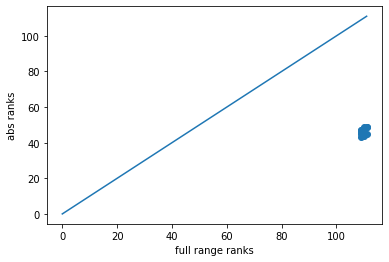

In [97]:
plt.scatter(ranks, ranks_abs)
plt.plot((0, max(ranks)), (0, max(ranks)))
plt.xlabel('full range ranks')
plt.ylabel('abs ranks')